In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../')
import tokamakTK
from tokamakTK import get_ECT_regression, HUEOrder, get_pi_matrix, clean_numerical_data, MyCounter

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
import plotly.subplots as plsp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.ticker as ticker



from collections import Counter

pd.set_option('display.max_columns', None)
plt.rc('font',family = 'serif')
plt.rc('axes', axisbelow=True)

path = "../data/"
fig_path = "../../../LATEX/Latex Images/"
plt.rcParams["mathtext.fontset"] = "cm"

In [5]:
# Obtained from Optimization

min_subset_ids_6357 = pd.read_csv(path+"R_ids_alpha_0.6357.csv")
min_subset_ids_9998 = pd.read_csv(path+"R_ids_alpha_0.9998.csv")
min_subset_ids_joe  = pd.read_csv(path+"deviation_id.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# Removing Spherical TOKAMAKS
#DB5 = DB5[~DB5["TOK"].isin(['START','MAST','NSTX'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label_6357",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_6357.id)].index), "label_6357"] = "Decreasing"

DB5.insert(loc=2,column="label_9998",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_9998.id)].index), "label_9998"] = "Decreasing"

DB5.insert(loc=2,column="label_joe",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_joe.id)].index), "label_joe"] = "Decreasing"

DB5.insert(loc=2,column="Spherical",value=["False"]*len(DB5))
DB5.loc[(DB5[DB5.TOK.isin(['START','MAST','NSTX'])].index), "Spherical"] = "True"

DB5.insert(0, 'intercept', np.ones(len(DB5)))


print(
    "  Subset that decrease alpha-R to 0.6357\n--------\n" +
    f"{ round( (len(min_subset_ids_6357)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_6357)/len(DB5))*100 ,2)  }% did not affect alpha_R" +
    "\n\n\n  Subset that decrease alpha-R to 0.9998\n--------\n" +
    f"{ round( (len(min_subset_ids_9998)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_9998)/len(DB5))*100 ,2)  }% did not affect alpha_R"
    "\n\n\n  Subset given by Joseph Hall           \n--------\n" +
    f"{ round( (len(min_subset_ids_joe)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_joe)/len(DB5))*100 ,2)  }% did not affect alpha_R"
)

  Subset that decrease alpha-R to 0.6357
--------
23.45% affected alpha_R
76.55% did not affect alpha_R


  Subset that decrease alpha-R to 0.9998
--------
9.88% affected alpha_R
90.12% did not affect alpha_R


  Subset given by Joseph Hall           
--------
18.46% affected alpha_R
81.54% did not affect alpha_R


In [6]:
DB5 = tokamakTK.clean_categorical_data(DB5)
# Needed for Improved Visualization: 2D and 3D Plots
HUE_ORDER, PX_ORDER = tokamakTK.get_colors_per_category(DB5)
hue_order = HUEOrder(HUE_ORDER)

# ---------------------------------------------------

# SPECIAL PARAMETERS
colors_ = sns.color_palette('tab20', 20)
HUE_ORDER["Spherical"] = dict(zip(sorted(DB5["Spherical"].unique()), colors_[:len(DB5["Spherical"].unique())]))
HUE_ORDER["label_joe"] = dict(zip(sorted(DB5["label_joe"].unique()), colors_[:len(DB5["label_joe"].unique())]))

In [7]:
DB5["DATE"] = DB5["DATE"].astype(str).replace(r"(\d{6})00", r"\g<1>01", regex=True)
DB5["DATE"] = pd.to_datetime(DB5["DATE"], format="%Y%m%d")
DB5["YEAR"] = DB5["DATE"].dt.year

In [8]:
# DECREASING
data1_64 = DB5[DB5.label_6357.isin(["Decreasing"])].reset_index(drop=True)
data1_99 = DB5[DB5.label_9998.isin(["Decreasing"])].reset_index(drop=True)

# UNAFFECTED
data2_64 = DB5[DB5.label_6357.isin(["Unaffected"])].reset_index(drop=True)
data2_99 = DB5[DB5.label_9998.isin(["Unaffected"])].reset_index(drop=True)

In [15]:
df = pd.DataFrame(DB5["YEAR"].value_counts()).rename(columns={"YEAR":"DB5"}).sort_index()

df = df.join(pd.DataFrame(data1_64["YEAR"].value_counts().sort_index()).rename(columns={"YEAR":"Tau_0.64"}))
df = df.join(pd.DataFrame(data2_64["YEAR"].value_counts().sort_index()).rename(columns={"YEAR":"Tau_2.16"}))
df = df.join(pd.DataFrame(data1_99["YEAR"].value_counts().sort_index()).rename(columns={"YEAR":"Tau_0.99"}))
df = df.join(pd.DataFrame(data2_99["YEAR"].value_counts().sort_index()).rename(columns={"YEAR":"Tau_1.71"}))

In [16]:
df90s = df[:18].sum()
df20s = df[18:27].sum()
df_else = df[27:].sum()

df90s = pd.DataFrame(df90s).T
df90s.index = ["date $\leq$ 1999"]

df20s = pd.DataFrame(df20s).T
df20s.index = ["1999 $<$ date $\leq$ 2009"] 

df_else = pd.DataFrame(df_else).T
df_else.index = ["2011 $\leq$ date $\leq$ 2017"]

In [17]:
df = pd.concat([df90s,df20s,df_else])
df = df.astype(int)

In [18]:
df = df[['Tau_0.64', 'Tau_2.16', 'DB5', 'Tau_0.99', 'Tau_1.71']]
df.columns=['$\\tau_{E,0.64}$', '$\\tau_{E,2.16}$', 'STDB5', '$\\tau_{E,0.99}$', '$\\tau_{E,1.71}$']

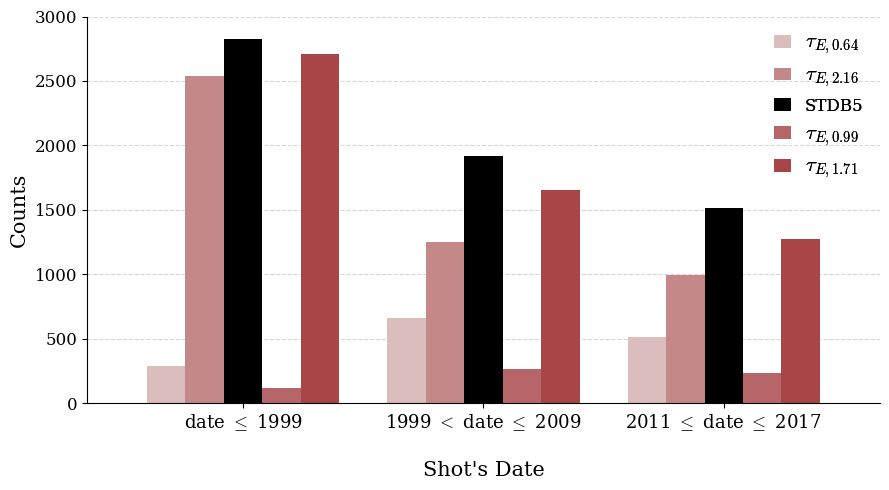

In [19]:
 
colors = sns.color_palette("light:#A84547", n_colors=100)[:]
my_colors = [colors[30], colors[60], (0, 0, 0), colors[80], colors[99]]

ax = df.plot(kind='bar', stacked=False, figsize=(9, 5), color=my_colors, width=0.8)

ax.set_xticklabels(df.index, rotation=0, fontsize=13)

# Set the legend
ax.legend(loc=0, frameon=False, fontsize=13, handlelength=0.8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticks(), fontsize=12)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

# Set the labels and title
ax.set_xlabel("\nShot's Date", fontsize=15)
ax.set_ylabel("Counts", fontsize=15)

# Get the handles and labels of the legend
handles, labels = ax.get_legend_handles_labels()

# Create a dictionary to map specific labels to their desired font size
label_sizes = {
    'STDB5': 12,
}

# Create a custom legend with modified label sizes
custom_legend = plt.legend(handles, labels, loc=0, frameon=False, fontsize=13, handlelength=0.9)

# Set the font size for specific legend labels
for text in custom_legend.get_texts():
    label = text.get_text()
    font_size = label_sizes.get(label, 15)  # Default font size is 15 if label not found in label_sizes
    text.set_fontsize(font_size)

# Add the custom legend to the plot
ax.add_artist(custom_legend)

ax.grid(alpha=0.5, axis='y', linestyle='--')

# Show the plot
plt.tight_layout()

#plt.savefig(fig_path+"shots_time_characterization.pdf", format="pdf", dpi=800, bbox_inches='tight');
plt.show()